# Navigation


# 1. Setup and Exploration
---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1.1 Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
import numpy as np
import pandas as pd
import random
import sys

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Agent and environment
import torch
from dqn_agent import Agent

from unityagents import UnityEnvironment

from collections import deque
# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")
# Brains are responsible for deciding actions
# Get first brain available
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 1.2 Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 1.3 Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


# 2. RL Agent training and evaluation

### 2.1 Training function

The training functions comprise of the `train_dqn()` function that creates and trains the agent and a second cell to call that function and plot the results after training. 

In [5]:
def train_dqn(n_episodes=1000, print_step = 10, score_success = 20
              ,eps_start=1.0, eps_end=0.01, eps_decay=0.995
              ,batch_size= 64,learn_step_size=10, buffer_size = 10000
              ,gamma = 0.99 , learning_rate = 5e-4 , tau = 1e-3 
              ,seed = 1
             ):
    """
    Creates and trains and agent with given parameter setting. Saves only succesfully agents.
    """
    
    # Init score variables and epsilon
    score = 0                                     
    scores_window = deque(maxlen=100)
    scores =  []
    solve_msg = ''
    step_cnt = 0
    eps = eps_start
    
    # Create agent  
    agent = Agent(state_size, action_size
                         ,batch_size,learn_step_size, buffer_size
                         ,gamma , learning_rate, tau
                         ,seed)
   
    # Loop over episodes
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        step_cnt = 0
        
        while True:
            action = agent.act(state, eps)                 # Retrieve best action for current policy
            env_info = env.step(action)[brain_name]        # Take action in environment
            next_state = env_info.vector_observations[0]   # Get the next state
            reward = env_info.rewards[0]                   # Get the reward
            done = env_info.local_done[0]                  # See if episode has finished 
            agent.step(state, action, reward, next_state, done) # Store info in experience memory     
            
            # Prepare for next step
            state = next_state                             
            score += reward                                
            step_cnt +=1
            
            # Exit loop if finished
            if done:      
                break
        
        # Reduce epsilon for less exploration
        eps = max(eps_end, eps_decay*eps)
        
        # Append and print scores
        scores.append(score)
        scores_window.append(score)
        
        if (solve_msg == '') & (np.mean(scores_window) > 13):
            solve_msg = f'-- Environment solved after {i_episode} episodes.'
            
        if (i_episode % print_step) == 0:
            print(f"Episodes: {i_episode} "," Avg Score: {0:.3f}".format( np.mean(scores_window)),solve_msg , '    ', end='\r')
            sys.stdout.flush()
    
    # Save agent if performance is good
    if np.mean(scores_window)>=13.0:
        print('\nSuccesful agent achieved an average score of {:.2f} and was saved.'.format( np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'agent.pth')

    return scores
    

Episodes: 1000   Avg Score: 15.620 -- Environment solved after 448 episodes.     
Succesful agent achieved an average score of 15.62 and was saved.


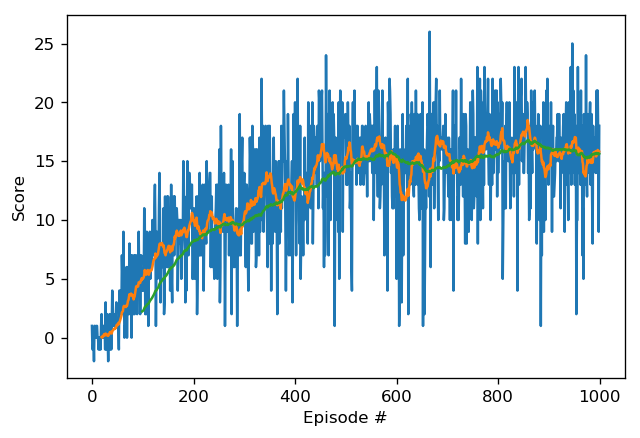

In [6]:
# INIT NUM
n_episodes    = 1000
print_step    = 5
score_success = 14


# Call training function
scores = train_dqn(n_episodes, print_step , score_success
                   ,eps_start=1.0, eps_end=0.0001, eps_decay=0.99
                   ,batch_size=32,learn_step_size=5, buffer_size= 10000
                   ,gamma = 0.99 , learning_rate = 5e-4 , tau = 1e-3 
                   ,seed =1
                  )



# Calculate avg scores 
se_scores     = pd.Series(scores)# dummy data
se_scores_20 =se_scores.rolling(20).mean()
se_scores_100 =se_scores.rolling(100).mean()

# Plot the scores
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
plt.plot(np.arange(len(se_scores)), se_scores)
plt.plot(np.arange(len(se_scores_20)),se_scores_20 )
plt.plot(np.arange(len(se_scores_100)),se_scores_100 )
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 2.2 Grid search

The next cell provides the framework for a grid search. The parameters for testing need to be entered in the param_grid and the grid search will provide the results and best parameter set. The `train_dqn()` function in the previous cells needs to be executed before.

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


 -- Parameter set: {'LR': 0.0005, 'batch_size': 32, 'buffer_size': 10000, 'eps_decay': 0.99, 'eps_end': 0.0001, 'eps_start': 1.0, 'gamma': 0.99, 'learn_step_size': 5, 'n_episodes': 500, 'seed': 1, 'tau': 0.01}
Episodes: 500 Score: 10.0 Score: 10.0 Avg Score: 13.830 Eps: 0.00657  Step cnt: 300     
______________________________________________________________________________

 -- Parameter set: {'LR': 0.0005, 'batch_size': 32, 'buffer_size': 10000, 'eps_decay': 0.99, 'eps_end': 0.0001, 'eps_start': 1.0, 'gamma': 0.99, 'learn_step_size': 5, 'n_episodes': 500, 'seed': 1, 'tau': 0.001}
Episodes: 500 Score: 8.0 Score: 8.0 Avg Score: 14.700 Eps: 0.00657  Step cnt: 300       
______________________________________________________________________________

 -- Parameter set: {'LR': 0.0005, 'batch_size': 32, 'buffer_size': 10000, 'eps_decay': 0.99, 'eps_end': 0.0001, 'eps_start': 1.0, 'gamma': 0.99, 'learn_step_size': 10, 'n_episodes': 500, 'seed': 1, 'tau': 0.01}
Episodes: 500 Score: 0.0 Score

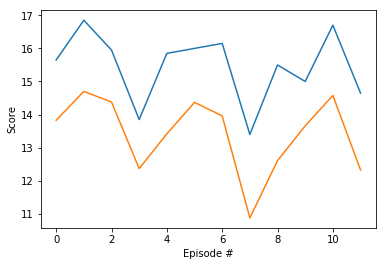

Best parameters: {'LR': 0.0005, 'batch_size': 32, 'buffer_size': 10000, 'eps_decay': 0.99, 'eps_end': 0.0001, 'eps_start': 1.0, 'gamma': 0.99, 'learn_step_size': 5, 'n_episodes': 500, 'seed': 1, 'tau': 0.001}


In [44]:
from sklearn.grid_search import ParameterGrid

# Set up testing parameter grid
param_grid = { 'n_episodes': [500]
              ,'eps_start' : [1.0]
              ,'eps_end'   : [0.0001]
              ,'eps_decay' : [0.99] 
              ,'batch_size': [32,64,128]
              ,'learn_step_size': [5,10]
              ,'buffer_size'   : [10000]
              ,'gamma': [0.99]
              ,'learning_rate': [5e-4 ]
              ,'tau': [1e-2,1e-3]
              ,'seed': [1]
          
             }
grid = ParameterGrid(param_grid) 

# Init score arrays
best_score    = []
end_avg_score = []
parameters    = []

# Parameter grid search
for params in grid:
    
    print(' -- Parameter set:' ,str(params).translate(str.maketrans({'o': 'O', 't': 'T'}))  )
    scores = train_dqn(params['n_episodes'], params['eps_start'] ,params['eps_end'], params['eps_decay']
          ,params['batch_size'], params['learn_step_size'], params['buffer_size']
          ,params['gamma'] , params['LR'],params['tau']
          , params['seed'])
    print('\n______________________________________________________________________________\n')
    
    
    # Calc average scores
    se_scores     = pd.Series(scores) 
    se_scores_20 = se_scores.rolling(20).mean()
    se_scores_100 = se_scores.rolling(100).mean()
    
    best_score.append(se_scores_20.max())
    end_avg_score.append(se_scores_100.iloc[-1])
    parameters.append(str(params))
    
    
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(parameters)), best_score)
plt.plot(np.arange(len(parameters)), end_avg_score )
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
print( 'Best parameter Set:', parameters[np.argmax(end_avg_score)])